In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import matplotlib.patches as mpatches
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import warnings
import optuna
import time
from itables import init_notebook_mode
from scipy import stats
init_notebook_mode(all_interactive=True)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
import sklearn.feature_selection as fs
from sklearn.feature_selection import SelectFromModel
from itertools import compress
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier

#oversampling
warnings.filterwarnings('ignore')
%matplotlib inline


In [ ]:
df = pd.read_csv("final_dataset.csv",index_col = 0)

In [ ]:
df.columns.to_list()

In [57]:
class Features:
    def __init__(self):
        pass

    dataset = pd.read_csv("new_dataset.csv", index_col=0)

    def dataset_preparation(self):
        cols_to_drop = ['Open', 'Diluted WASO']
        self.dataset = self.dataset.drop(columns=cols_to_drop)
        missing_values = self.dataset.isnull().sum()
        print('missing_values: \n', missing_values)
        self.dataset = self.dataset.fillna(0)
        inf_values = self.dataset.isin([np.inf, -np.inf]).any()
        print('inf values: \n',inf_values[inf_values].index.tolist())
        self.dataset.replace([np.inf, -np.inf], 0, inplace=True)
        self.dataset['Return'] = self.dataset['return']
        self.dataset = self.dataset.drop(columns=['return'])

    X = None
    Y = None

    @staticmethod
    def convert_sequential_to_categorical(value):
        if value >= 0.1:
            return 1
        else:
            return 0
    
    def convert_to_classification(self):
        self.dataset['Return'] = self.dataset['Return'].apply(self.convert_sequential_to_categorical)

    def create_X_Y(self):
        self.X = self.dataset.iloc[:, :-1]
        self.Y = self.dataset.iloc[:, -1]
        print('X: ',self.X.shape)
        print('Y: ',self.Y.shape)
        return

    def prunLowVariance(self):
        var = fs.VarianceThreshold(threshold=0.5)
        var.fit(self.X)
        self.X  = var.transform(self.X)
        print("X with high variance: ", self.X.shape)
        return    
    
    X_scaled = None
    X_selected = None
    
    def scale_data(self):
        scaler = StandardScaler(with_mean=False) # no mean?
        self.X_scaled = scaler.fit_transform(self.X)

    def featureSelection(self):
        feature_names = self.dataset.columns.to_list()[:-1]
        
        X = self.dataset.iloc[:, :-1]
        Y = self.dataset.iloc[:, -1]
        
        sfm_selector = SelectFromModel(estimator=RandomForestClassifier())
        sfm_selector.fit(X, Y)
        list_of_selected_features = list(compress(feature_names, sfm_selector.get_support().tolist()))
        print("selected features based on Random Forest: ", list_of_selected_features)


        # Assuming X and Y are your feature matrix and target vector
        # Define the number of features you want to select
        k_features = 20

        # Create SVR estimator
        estimator = SVC()

        # Perform feature selection

        # explain f refression metric
        selector = SelectKBest(score_func=f_classif, k=k_features)
        selected = selector.fit_transform(X, Y)

        # Get selected feature indices
        selected_indices = selector.get_support(indices=True)

        # Get selected feature names
        selected_feature_names = [feature_names[i] for i in selected_indices]

        print("Selected features based on SVM: ", selected_feature_names)

        common_features_selected = list(set(selected_feature_names).intersection(list_of_selected_features))
        print("Features selected: ",common_features_selected)
        self.X_selected = X[common_features_selected]

    def plot_feature_selection(self):
        model = SVC()
        score_list = []
        for k in range(1, 15):
            best_k = fs.SelectKBest(score_func=fs.f_classif, k=k)
            best_k.fit(self.X, self.Y)
            X_trans = best_k.transform(self.X)
            train_x, test_x, train_y, test_y = train_test_split(X_trans,
                                                                self.Y,
                                                                test_size=0.2,
                                                                random_state=42)
            model.fit(train_x, train_y)
            y_pred = model.predict(test_x)
            score = metrics.accuracy_score(test_y, y_pred)
            score_list.append(score)

        fig, axe = plt.subplots(dpi = 300)
        axe.plot(range(1, 15), score_list)
        axe.set_xlabel("best k features")
        axe.set_ylabel("Accuracy")
        #fig.savefig("output/img.png")
        #plt.close(fig)

    def plot_feature_importances(self):
        # Fit SVR model
        svr = SVC()
        svr.fit(self.X, self.Y)

        # Compute distances from the decision boundary (the hyperplane)
        distances = svr.predict(self.X) - self.Y

        # Calculate importance scores for each feature based on distances from the decision boundary
        feature_importances = np.abs(np.dot(self.X.T, distances))

        # Normalize feature importances
        feature_importances /= feature_importances.sum()

        # Plot feature importances
        plt.figure(figsize=(20, 12))
        plt.barh(range(len(feature_importances)), feature_importances, align='center')
        plt.yticks(np.arange(len(feature_importances)), self.dataset.columns.to_list()[:-1])
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
        plt.title('SVR Feature Importances (RBF Kernel)')
        plt.show()


        # Fit Random Forest model
        rf = RandomForestClassifier()
        rf.fit(self.X, self.Y)

        # Get feature importances
        feature_importances = rf.feature_importances_

        plt.figure(figsize=(12, 10))
        plt.barh(self.dataset.columns.to_list()[:-1], feature_importances, align='center')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
        plt.title('Random Forest Feature Importances')
        plt.show()

    def compare_methods(self,withSelection=False,withScale=False):

        if withScale:
            x = self.X_scaled

        elif withSelection:
            x = self.X_selected

        else:
            x = self.X
        print(x.shape)
        
        x_train, x_test, y_train, y_test = train_test_split(x, self.Y, test_size=0.20, random_state=1, shuffle=True)
        
        models = []

        models.append(("LogisticRegression", LogisticRegression()))
        models.append(("DecisionTree", DecisionTreeClassifier()))
        models.append(("SVM", SVC()))
        models.append(("RandomForest", RandomForestClassifier()))
        models.append(("Naive Bayess",GaussianNB()))

        train_times = []
        test_times = []
        results = []
        names = []

        for name, model in models:
            if model is not None:
                result = cross_val_score(model, x, self.Y, cv=6, scoring='accuracy')
                results.append(result)
            start_time = time.time()
            model.fit(x_train, y_train)
            train_time = time.time() - start_time
            
            start_time = time.time()
            score = model.score(x_test, y_test)
            test_time = time.time() - start_time
            
            names.append(name)
            train_times.append(train_time)
            test_times.append(test_time)
            

        # Plotting
        plt.figure(figsize=(10, 10))
        plt.barh(names, train_times, color='blue', label='Training Time')
        plt.barh(names, test_times, color='red', label='Testing Time', alpha=0.5)
        plt.xlabel('Time (seconds)')
        if withScale:
            plt.title('Comparison of Training and Testing Times for Different Classifiers (Scaled Data)')
        elif withSelection:
            plt.title('Comparison of Training and Testing Times for Different Classifiers (Selected Features)')
        else:
            plt.title('Comparison of Training and Testing Times for Different Classifiers')
        plt.legend()
        plt.show()

        means = []
        for i in range(len(names)):
            means.append(results[i].mean())
        plt.figure(figsize=(10, 10))
        plt.bar(names, means)
        if withScale:
            plt.title("Performance comparison (Accuracy) [Scaled Data]")
        elif withSelection:
            plt.title("Performance comparison (Accuracy) [Selected Features]")
        else:
            plt.title("Performance comparison (Accuracy)")

        plt.show()

    def export_X_Y(self):
        X_df = pd.DataFrame(self.X_selected)
        X_df.to_csv('X.csv', index=False)
        Y_df = pd.DataFrame(self.Y)
        Y_df.to_csv('Y.csv', index=False)

In [58]:
experiments = Features()
experiments.dataset_preparation()
experiments.convert_to_classification()

missing_values: 
 Total Assets                                                      0
Total Current Assets                                              0
Total Non-Current Assets                                          0
Total Liabilities                                                 0
Total Current Liabilities                                         0
Total Non-Current Liabilities                                     0
Total Equity                                                      0
Cash Generated from Operating Activities                          0
Income/Loss before Non-Cash Adjustment                            0
Changes in Operating Capital                                      0
Cash Flow from Investing Activities                               0
Cash Flow from Financing Activities                               0
Change in Cash                                                    0
Cash and Cash Equivalents, Beginning of Period                    0
Gross Profit                  

In [59]:
experiments.featureSelection()

selected features based on Random Forest:  ['Cash Generated from Operating Activities', 'Changes in Operating Capital', 'Cash Flow from Investing Activities', 'Cash Flow from Financing Activities', 'Change in Cash', 'Diluted EPS', 'Gross Margin', 'Net Income to Total Assets ratio', 'Gross Profit to Total Assets ratio', 'Price to Total Current Assets ratio', 'Price to Cash Generated from Operating Activities ratio', 'Price to Changes in Operating Capital ratio', 'Price to Cash Flow from Investing Activities ratio', 'Price to Cash Flow from Financing Activities ratio', 'Price to Change in Cash ratio', 'Price to Total Operating Profit/Loss ratio', 'Price to Diluted EPS ratio']
Selected features based on SVM:  ['Total Non-Current Assets', 'Total Non-Current Liabilities', 'Income/Loss before Non-Cash Adjustment', 'Cash Flow from Investing Activities', 'Cash Flow from Financing Activities', 'Total Operating Profit/Loss', 'Net Income', 'Gross Margin', 'Net Income to Total Assets ratio', 'Net 

In [61]:
experiments.create_X_Y()
experiments.prunLowVariance()
experiments.scale_data()

X:  (3944, 47)
Y:  (3944,)
X with high variance:  (3944, 43)


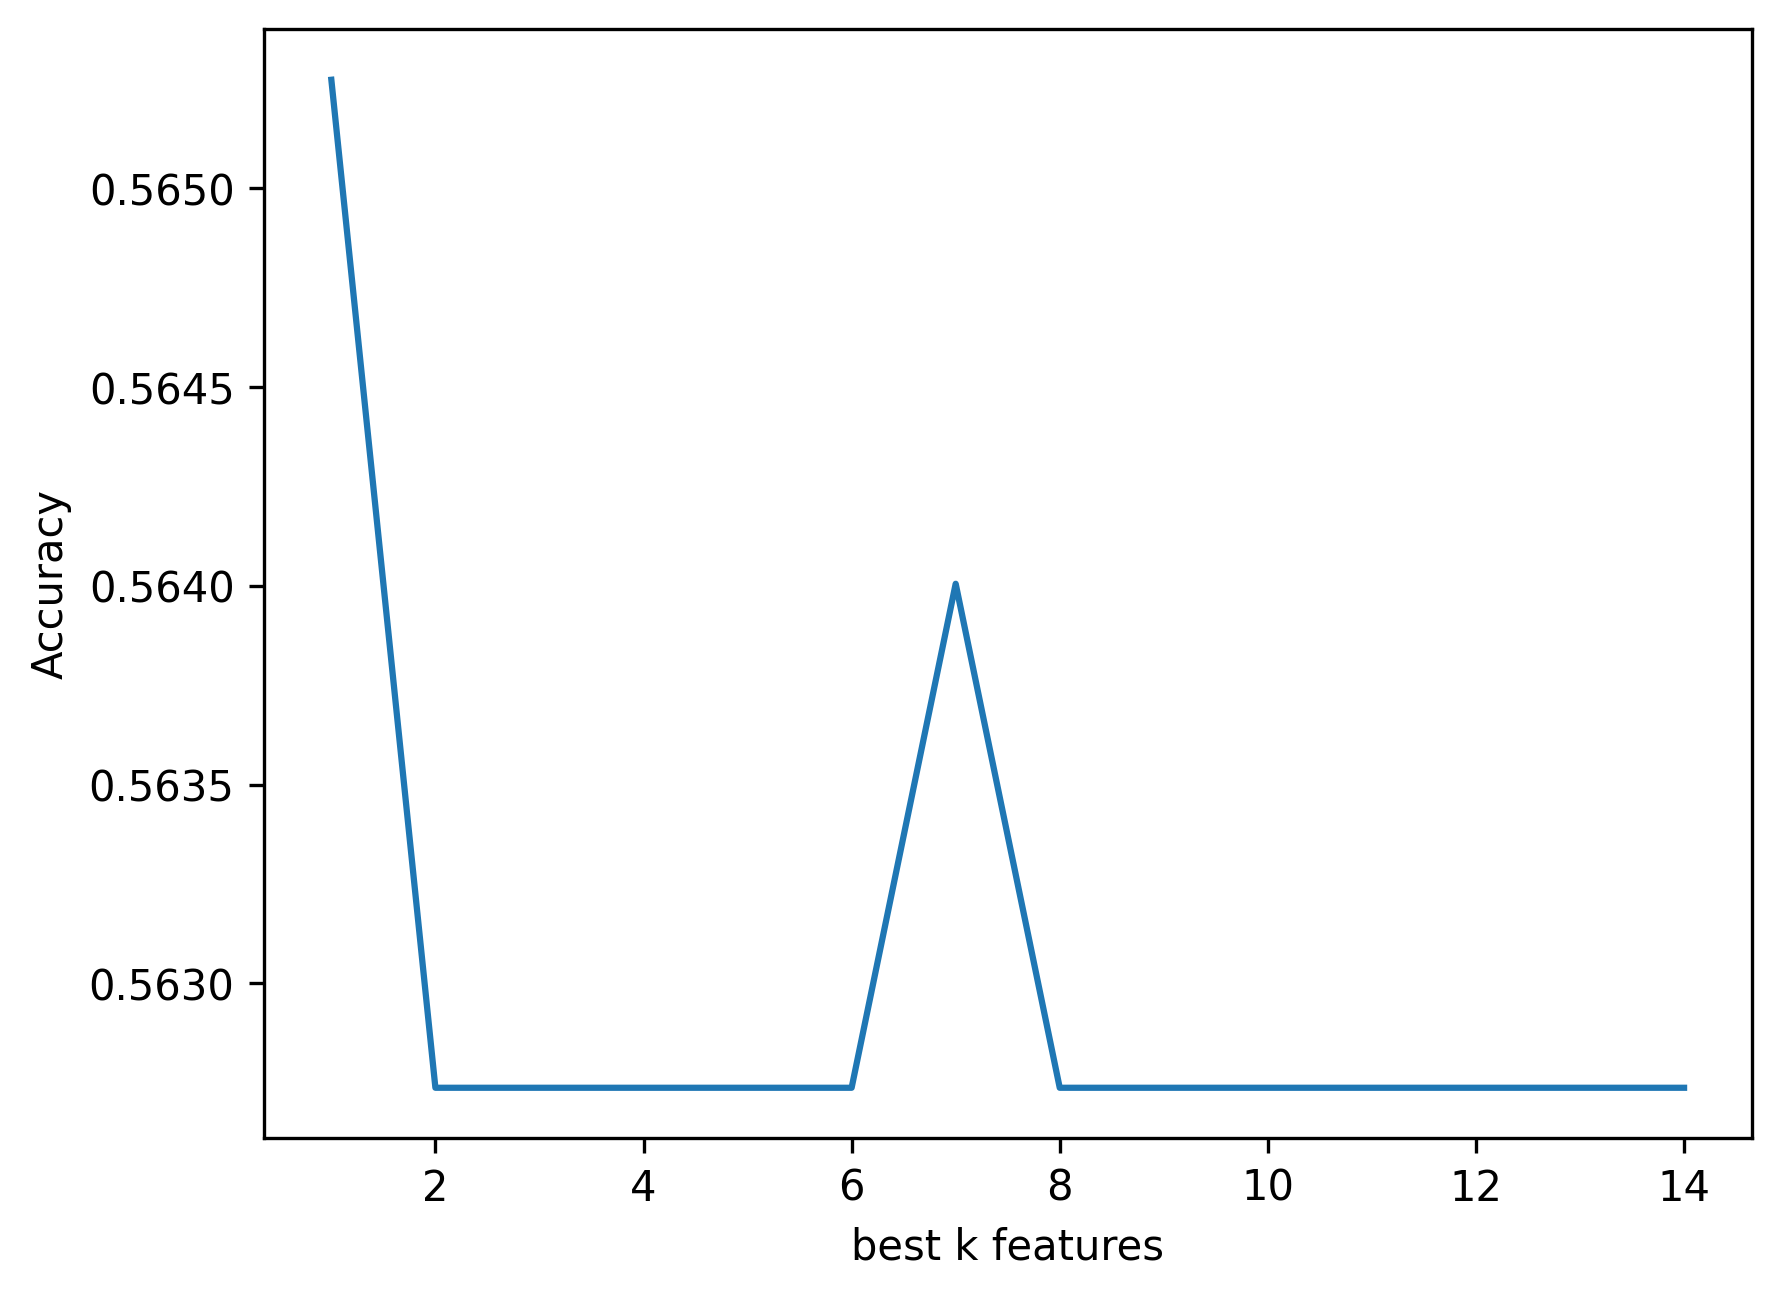

In [62]:
experiments.plot_feature_selection()


ValueError: The number of FixedLocator locations (43), usually from a call to set_ticks, does not match the number of labels (47).

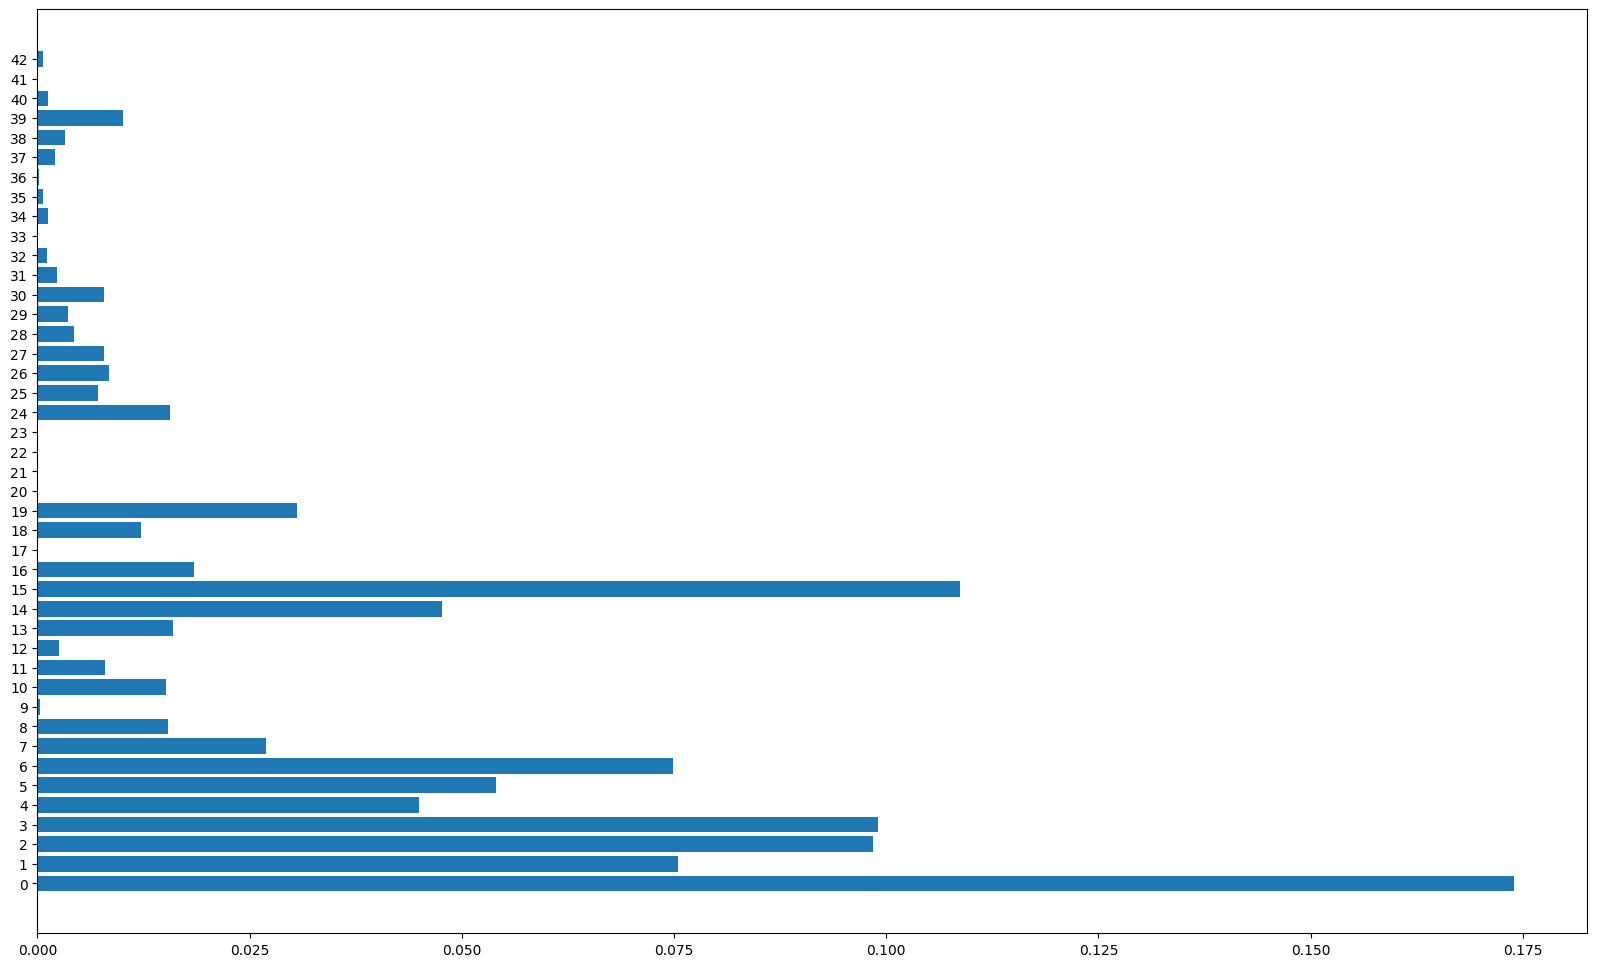

In [63]:
experiments.plot_feature_importances()


(3944, 43)


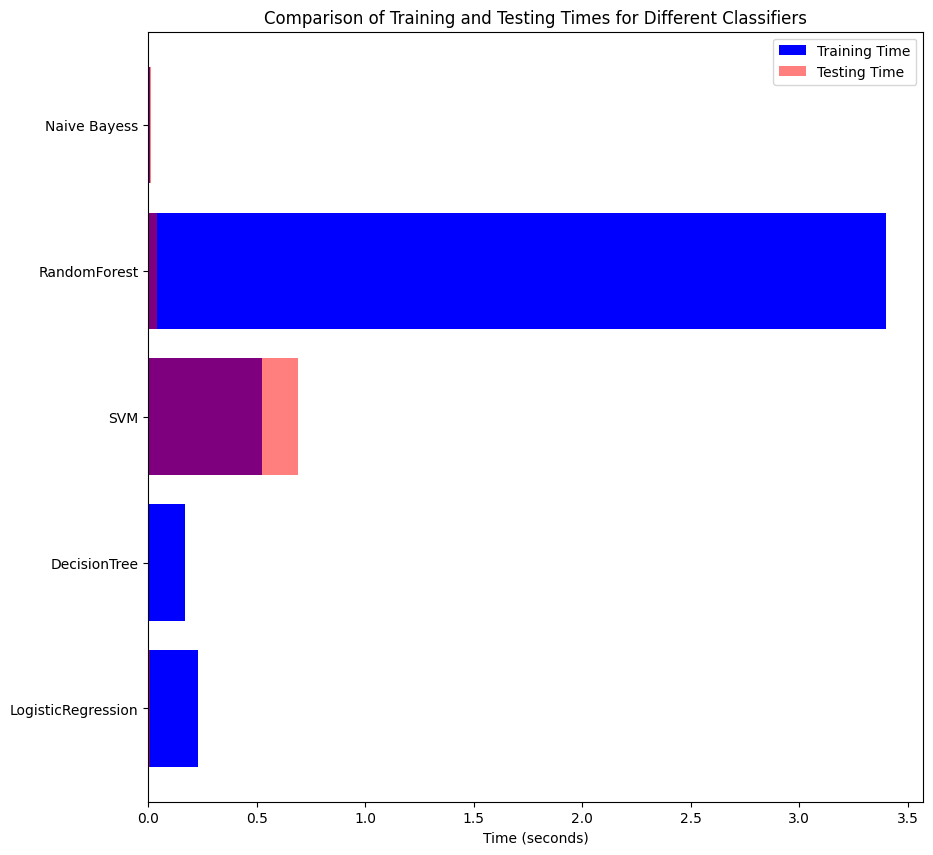

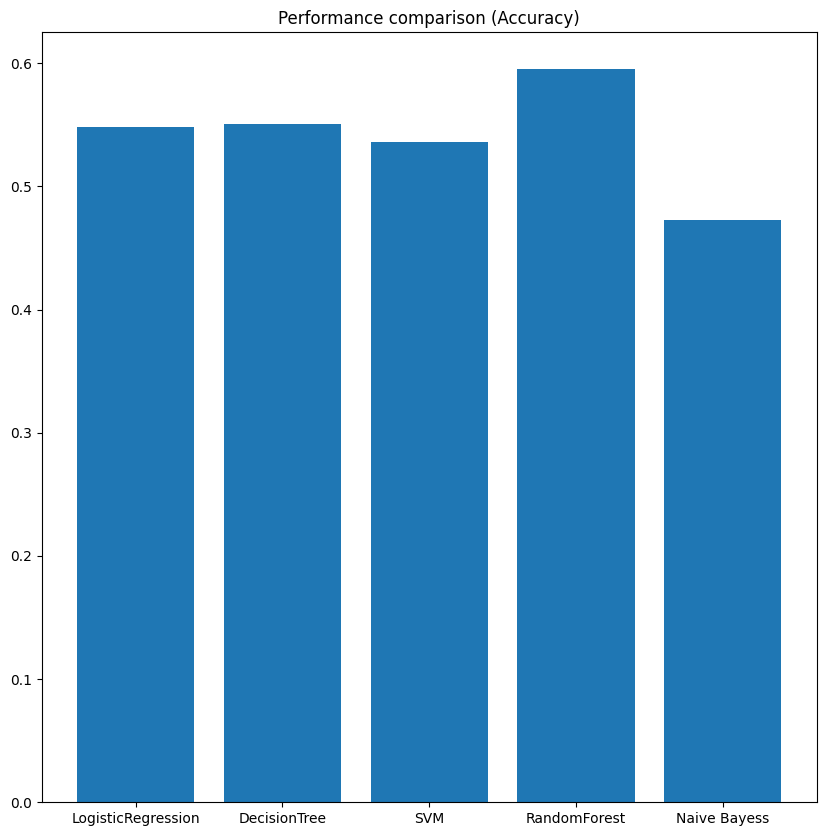

In [54]:
experiments.compare_methods()

(3944, 43)


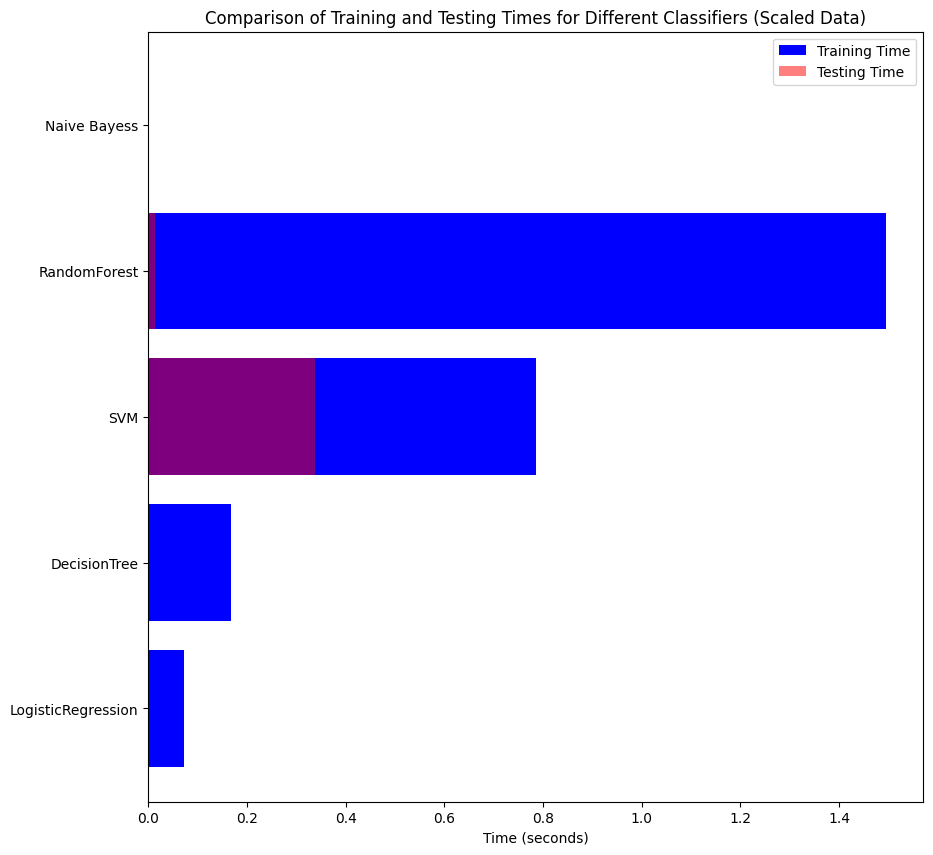

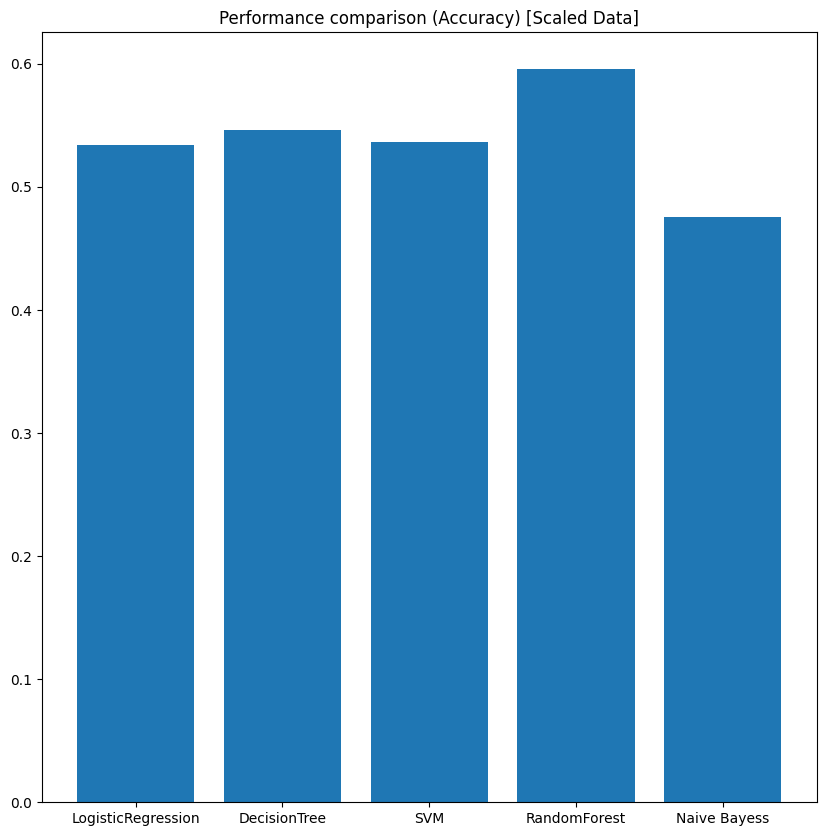

In [55]:
experiments.compare_methods(withScale=True)

(3944, 12)


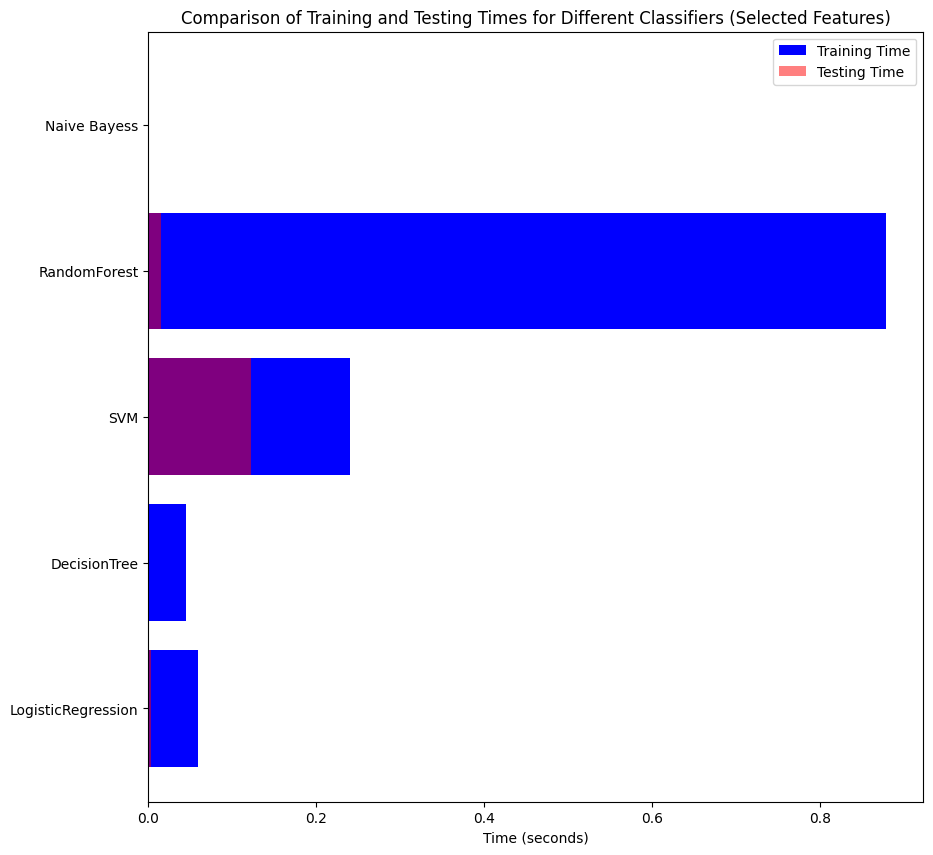

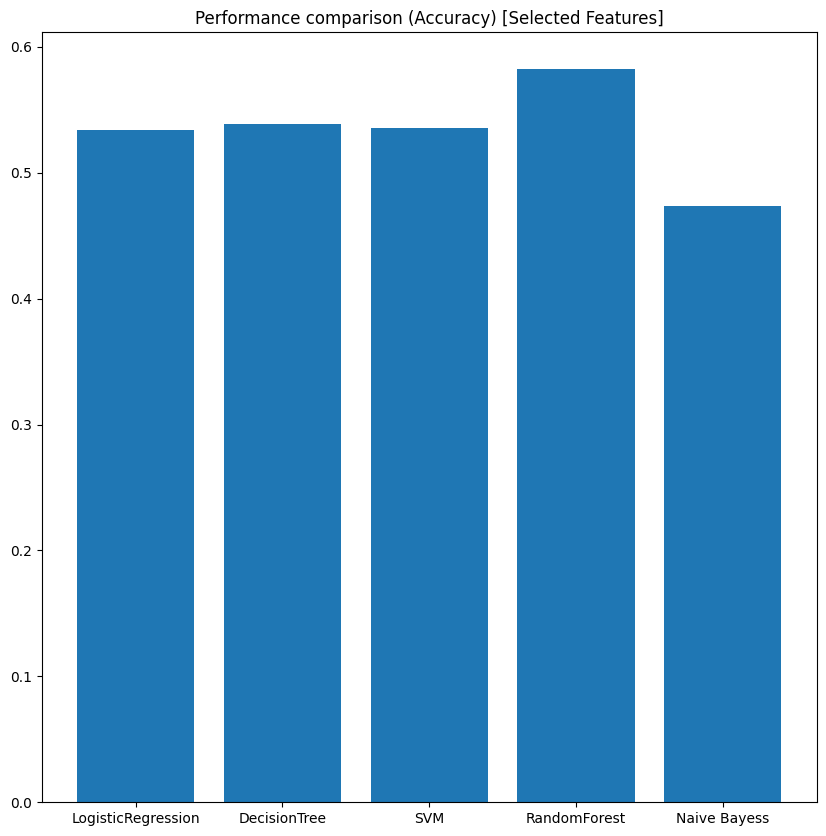

In [56]:
experiments.compare_methods(withSelection=True)

In [ ]:
experiments.export_X_Y()